In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression

# Data for

In [2]:
#data_for = '_PredMP'

data_for = '_ExpMP'

#data_for = '_NoMP'

In [3]:
file_path = "../Exp_1_Raw_Dataset/Raw_dataset_dataset_20240705.csv"

data = pd.read_csv(file_path)

In [4]:
data = data.sort_values('Type', ascending=False)
data = data.reset_index(drop = True)
data

,Drug,Solvent_1,Solvent_mass_fraction,Solvent_mol_fraction,Solvent_2,Temperature (K),Drug_Collected_Melting_temp (K),Drug_Predicted_Melting_temp (K),Drug_SMILES,Drug_Maccs_1,...,Solvent_2_fr_thiazole,Solvent_2_fr_thiocyan,Solvent_2_fr_thiophene,Solvent_2_fr_unbrch_alkane,Solvent_2_fr_urea,Solubility (g/100g),LogS,Class,Drug-solvent system,Type
0,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.925052,0.940600,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0,0,0,0,0,27.381751,1.437461,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
1,Flutamide,2-Propanol,0.200000,0.069743,Water,318.15,384.650000,393.15,C(F)(F)(F)C1=C(N(=O)=O)C=CC(NC(C(C)C)=O)=C1,0,...,0,0,0,0,0,0.185417,-0.731851,"[-5.48, -0.43]",Flutamide-2-Propanol/Water,Train
2,Flutamide,2-Propanol,1.000000,1.000000,Water,318.15,384.650000,393.15,C(F)(F)(F)C1=C(N(=O)=O)C=CC(NC(C(C)C)=O)=C1,0,...,0,0,0,0,0,45.841147,1.661255,"(1.0, 1.99]",Flutamide-2-Propanol/Water,Train
3,Flutamide,2-Propanol,0.900000,0.729656,Water,318.15,384.650000,393.15,C(F)(F)(F)C1=C(N(=O)=O)C=CC(NC(C(C)C)=O)=C1,0,...,0,0,0,0,0,39.381287,1.595290,"(1.0, 1.99]",Flutamide-2-Propanol/Water,Train
4,Flutamide,2-Propanol,0.800000,0.545362,Water,318.15,384.650000,393.15,C(F)(F)(F)C1=C(N(=O)=O)C=CC(NC(C(C)C)=O)=C1,0,...,0,0,0,0,0,30.778296,1.488245,"(1.0, 1.99]",Flutamide-2-Propanol/Water,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,Celecoxib,Ethanol,0.200000,0.089083,Water,313.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,0,0,0,0,0,0.003120,-2.505811,NaN,Celecoxib-Ethanol/Water,Lab
26726,Celecoxib,Ethanol,0.800000,0.610093,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,0,0,0,0,0,4.842238,0.685046,NaN,Celecoxib-Ethanol/Water,Lab
26727,Celecoxib,Ethanol,0.500000,0.281185,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,0,0,0,0,0,0.445512,-0.351141,NaN,Celecoxib-Ethanol/Water,Lab
26728,Celecoxib,Ethanol,0.200000,0.089083,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,0,0,0,0,0,0.000869,-3.061188,NaN,Celecoxib-Ethanol/Water,Lab


In [5]:
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [6]:
cols_to_drop = ['Drug','Solvent_1', 'Solvent_2',  
                 'Drug-solvent system', 'Solubility (g/100g)', 'LogS', 'Class', 'Drug_SMILES', 'Type']

if data_for == '_ExpMP':
    cols_to_drop = cols_to_drop + ['Drug_Predicted_Melting_temp (K)']
elif data_for == '_PredMP':
    cols_to_drop = cols_to_drop + ['Drug_Collected_Melting_temp (K)']
elif data_for == '_NoMP':
    cols_to_drop = cols_to_drop + ['Drug_Predicted_Melting_temp (K)'] + ['Drug_Collected_Melting_temp (K)']
else:
    print("Something wrong")

cols_to_drop

['Drug',
 'Solvent_1',
 'Solvent_2',
 'Drug-solvent system',
 'Solubility (g/100g)',
 'LogS',
 'Class',
 'Drug_SMILES',
 'Type',
 'Drug_Predicted_Melting_temp (K)']

In [7]:
X_train = train.drop(cols_to_drop, axis = 1)
X_test = test.drop(cols_to_drop, axis = 1)
X_lab = lab.drop(cols_to_drop, axis = 1)

In [8]:
X_train.shape

(19896, 1134)

In [9]:
X_lab.shape

(24, 1134)

# Remove the identical columns

In [10]:
variance = X_train.var()

columns_to_drop = variance[variance == 0].index

X_train = X_train.drop(columns=columns_to_drop)

X_train.shape

(19896, 718)

# Remove the highly correlated columns

In [11]:
def reduce_columns_by_correlation(data, threshold):
    corr_matrix = data.corr().abs()
    columns_to_drop = set()
    results_data = []

    for col in data.columns[:-1]:
        if col not in columns_to_drop:
            high_corr_columns = corr_matrix.loc[col, corr_matrix.loc[col, :] > threshold].index.tolist()
            
            if col in high_corr_columns:
                high_corr_columns.remove(col)

            columns_to_drop.update(high_corr_columns)
            results_data.append({'iteration': col, 'columns left': len(data.columns) - len(columns_to_drop)})

    data = data.drop(columns=list(columns_to_drop))


    return data


In [12]:
X_train = reduce_columns_by_correlation(X_train, 0.8)
X_train.shape

(19896, 362)

In [13]:
X_test = X_test[X_train.columns]
X_lab = X_lab[X_train.columns]

In [14]:
scaler = StandardScaler()
pca = PCA()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_lab_scaled = scaler.transform(X_lab)


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_lab_scaled_df = pd.DataFrame(X_lab_scaled, columns = X_lab.columns)


pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_lab_pca = pca.transform(X_lab_scaled)

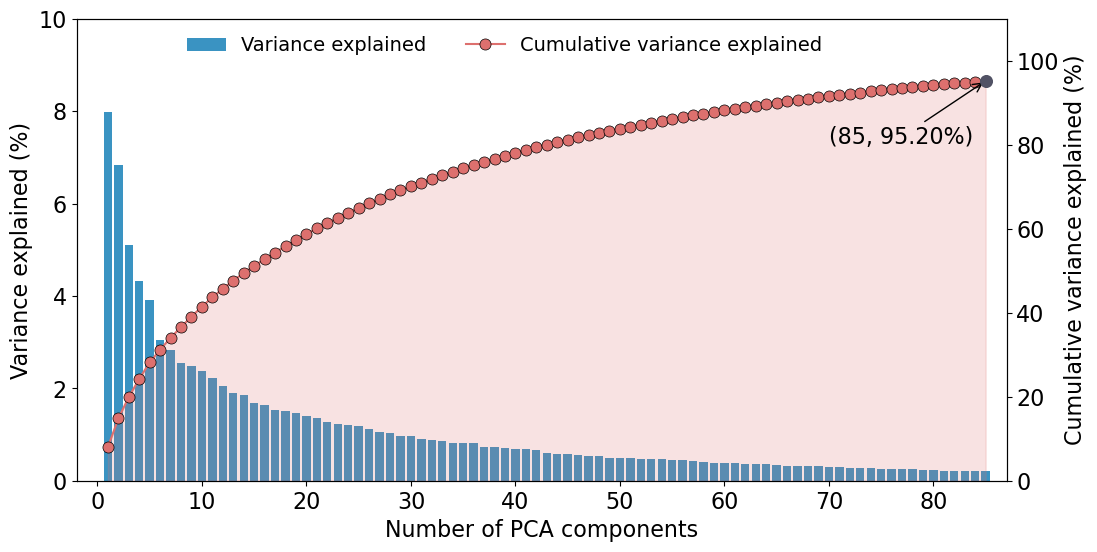

In [15]:
red = '#DD706E'
grey = '#515265'
yellow = '#FAAF3A'
blue = '#3A93C2'


threshold = 0.95

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
pc_number_threshold = np.argmax(cumulative_explained_variance >= threshold) + 1


pca_summary_threshold = pd.DataFrame({
    'PCA': range(1, pc_number_threshold + 1),
    'Variance': explained_variance_ratio[:pc_number_threshold] * 100,
    'Cumulative Variance': cumulative_explained_variance[:pc_number_threshold] * 100
})


fontsize = 16
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(pca_summary_threshold['PCA'], pca_summary_threshold['Variance'], alpha=1.0, label='Variance explained', color=blue)


ax2 = ax1.twinx()

ax2.plot(pca_summary_threshold['PCA'], pca_summary_threshold['Cumulative Variance'], 
         marker='o', markersize=8, markeredgewidth=0.5, markeredgecolor='black', 
         linestyle='-', color=red, label='Cumulative variance explained')



ax2.fill_between(pca_summary_threshold['PCA'], 0.0, pca_summary_threshold['Cumulative Variance'], color=red, alpha=0.2)


last_pca = pca_summary_threshold['PCA'].iloc[-1]
last_cumulative_variance = pca_summary_threshold['Cumulative Variance'].iloc[-1]
ax2.scatter(last_pca, last_cumulative_variance, color=grey, zorder=5, s = 70)  


ax2.annotate(f'({last_pca}, {last_cumulative_variance:.2f}%)', 
             xy=(last_pca, last_cumulative_variance), 
             xytext=(last_pca-15, last_cumulative_variance-15),
             fontsize=fontsize,
             arrowprops=dict(facecolor='black', arrowstyle='->'))


ax1.set_title('', fontsize=fontsize)
ax1.set_xlabel('Number of PCA components', fontsize=fontsize)
ax1.set_ylabel('Variance explained (%)', fontsize=fontsize)
ax2.set_ylabel('Cumulative variance explained (%)', fontsize=fontsize)


ax1.set_ylim(0, 10)
ax2.set_ylim(0, 110)
ax2.set_xlim(-2, last_pca+2)


ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='y', which='major', labelsize=fontsize)


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
lgd = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.1, 1), fontsize=fontsize-2, frameon=False, ncol=2)


ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)
ax1.grid(False)


fig.canvas.print_figure('Figure_SI' + data_for + '_PCA.png', dpi=600)

plt.show()

In [16]:
feat_to_keep = [f"PC{i+1}" for i in range(pc_number_threshold)]
pca_all_feat = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
col_to_add = ['Drug','Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)']


In [17]:
def dataset_generator(X_train_array, X_test_array, X_lab_array, data, all_feat, feat_to_keep, col_to_add):
    
    X_train = pd.DataFrame(X_train_array, columns = all_feat)
    X_test = pd.DataFrame(X_test_array, columns = all_feat)
    X_lab = pd.DataFrame(X_lab_array, columns = all_feat)
    
    X_train = X_train[feat_to_keep]
    X_test = X_test[feat_to_keep]
    X_lab = X_lab[feat_to_keep]
    
    X_train['Type'] = 'Train'
    X_test['Type'] = 'Test'
    X_lab['Type'] = 'Lab'
    
    combined_df = pd.concat([X_train, X_test, X_lab], ignore_index=True)
    
    for col in col_to_add:
        combined_df[col] = data[col]
        
    train_subset = combined_df[combined_df['Type'] == 'Train']
    test_subset = combined_df[combined_df['Type'] == 'Test']
    

    overlapping_groups = set(train_subset['Drug-solvent system']).intersection(set(test_subset['Drug-solvent system']))
    
    if (combined_df['Type'].equals(data['Type'])):
        print('First check:  passed')     
    else:
        print('First check:  failed')
        
    if (combined_df['LogS'].equals(data['LogS'])):
        print('Second check: passed')     
    else:
        print('Second check: failed')
        
    if (combined_df['Drug'].equals(data['Drug'])):
        print('Third check:  passed')     
    else:
        print('Third check:  failed')
    
    print("Number of overlapping train/test groups: ", len(overlapping_groups))
    
    return combined_df

In [18]:
dataset_PCA = dataset_generator(X_train_array = X_train_pca, X_test_array = X_test_pca, 
                                X_lab_array = X_lab_pca,
                                data = data, all_feat = pca_all_feat, 
                                feat_to_keep = feat_to_keep, col_to_add = col_to_add)
dataset_PCA.shape


First check:  passed
Second check: passed
Third check:  passed
Number of overlapping train/test groups:  0


(26730, 93)

In [19]:
dataset_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC84,PC85,Type,Drug,Solvent_1,Solvent_2,Drug-solvent system,LogS,Class,Solubility (g/100g)
0,-2.016437,5.349472,4.123902,6.724565,9.475266,-3.731394,-4.495168,0.968454,4.626369,-6.343464,...,0.676934,0.161230,Train,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,4-Methyl-2-pentanone,"1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",1.437461,"(1.0, 1.99]",27.381751
1,0.244788,-0.417283,3.907839,-7.090511,4.876596,-0.496192,-2.683063,-0.908109,-3.362110,3.078386,...,-0.133715,-0.096255,Train,Flutamide,2-Propanol,Water,Flutamide-2-Propanol/Water,-0.731851,"[-5.48, -0.43]",0.185417
2,0.224725,-0.486662,3.947651,-7.160114,4.891690,-0.529813,-2.684860,-0.890595,-3.340013,3.083737,...,-0.135817,-0.287343,Train,Flutamide,2-Propanol,Water,Flutamide-2-Propanol/Water,1.661255,"(1.0, 1.99]",45.841147
3,0.227233,-0.477990,3.942675,-7.151414,4.889803,-0.525611,-2.684635,-0.892784,-3.342775,3.083068,...,-0.135554,-0.263457,Train,Flutamide,2-Propanol,Water,Flutamide-2-Propanol/Water,1.595290,"(1.0, 1.99]",39.381287
4,0.229741,-0.469317,3.937698,-7.142714,4.887916,-0.521408,-2.684411,-0.894974,-3.345537,3.082399,...,-0.135291,-0.239571,Train,Flutamide,2-Propanol,Water,Flutamide-2-Propanol/Water,1.488245,"(1.0, 1.99]",30.778296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,-0.080607,-3.652239,0.663423,-5.846811,5.780773,1.611714,-1.185209,-0.369428,-6.353650,4.922308,...,-1.511938,1.327541,Lab,Celecoxib,Ethanol,Water,Celecoxib-Ethanol/Water,-2.505811,NaN,0.003120
26726,-0.089157,-3.721915,0.693642,-5.914622,5.776888,1.587318,-1.165642,-0.359245,-6.374123,4.905230,...,-1.762185,1.077455,Lab,Celecoxib,Ethanol,Water,Celecoxib-Ethanol/Water,0.685046,NaN,4.842238
26727,-0.081633,-3.695898,0.678713,-5.888521,5.771228,1.599926,-1.164968,-0.365813,-6.382410,4.903223,...,-1.761397,1.149113,Lab,Celecoxib,Ethanol,Water,Celecoxib-Ethanol/Water,-0.351141,NaN,0.445512
26728,-0.074110,-3.669881,0.663783,-5.862419,5.765568,1.612534,-1.164294,-0.372381,-6.390696,4.901216,...,-1.760609,1.220771,Lab,Celecoxib,Ethanol,Water,Celecoxib-Ethanol/Water,-3.061188,NaN,0.000869


In [20]:
dataset_PCA.to_csv('Summary_and_dataset/PCA_dataset' + data_for + '.csv', index = False)

In [21]:
X_train_scaled_df.shape

(19896, 362)

In [22]:
train['LogS'].shape

(19896,)

In [23]:
refined_dataset = dataset_generator(X_train_array = X_train_scaled, X_test_array = X_test_scaled, 
                                X_lab_array = X_lab_scaled,
                                data = data, all_feat = X_train.columns, 
                                feat_to_keep = X_train_scaled_df.columns, col_to_add = col_to_add)
refined_dataset.shape


First check:  passed
Second check: passed
Third check:  passed
Number of overlapping train/test groups:  0


(26730, 370)

In [24]:
refined_dataset.to_csv('Summary_and_dataset/refined_dataset' + data_for + '.csv', index = False)
